<a href="https://colab.research.google.com/github/manisankar29/MINOR-2/blob/main/X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240506%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240506T175841Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d3acd6e16b76c1978bcb242bc504f9898dccec6937b57167e193a24b5900116261804339ef1c6820e13c73245b266f11e62c26af7d76ad64e026f6f18f7a4efe35ef1e6989e6f516e08946a44f49a51111c0ceb2951c79c8abf1d453f88cc844943789f60690c467d58e5c1a111b0a5078d5ce169558ccba38290bc1bd35dee2cdcb9d108b0b61a21f9e5e408263fd4d6a7519cd6273b25b8082a4e8b733c55f268caa6128e08731e5073dc5aa2c885a9366b0092b944bd90dda28ed34b020876741b643f1613c868f337e25f7572a541b13677e71d59428d4bfc6f424b9f3ec31c98334f3c0d44ae16873cfb5dec89e852b578447bed2eaab6856154bf95fd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


# X-Ray Images ( Pneumonia) Classification with ResNet50

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping

## Loading Data & Data Processing

In [ ]:
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"

In [ ]:
normal = glob.glob(train_path+"NORMAL/*.jpeg")
pneumonia = glob.glob(train_path+"PNEUMONIA/*.jpeg")

In [ ]:
number_of_normal_img = len(normal)
number_of_pneumonia_img = len(pneumonia)
print("number of normal images:", number_of_normal_img)
print("number of pneumonia images:", number_of_pneumonia_img)

number of normal images: 1341
number of pneumonia images: 3875


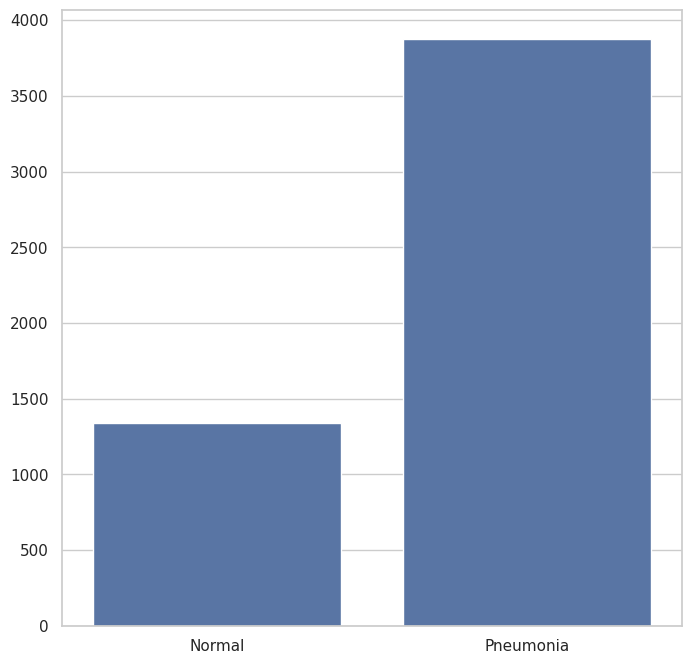

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (8,8))
ax = sns.barplot( x = ["Normal", "Pneumonia"], y = [number_of_normal_img, number_of_pneumonia_img])

## Data Visualization

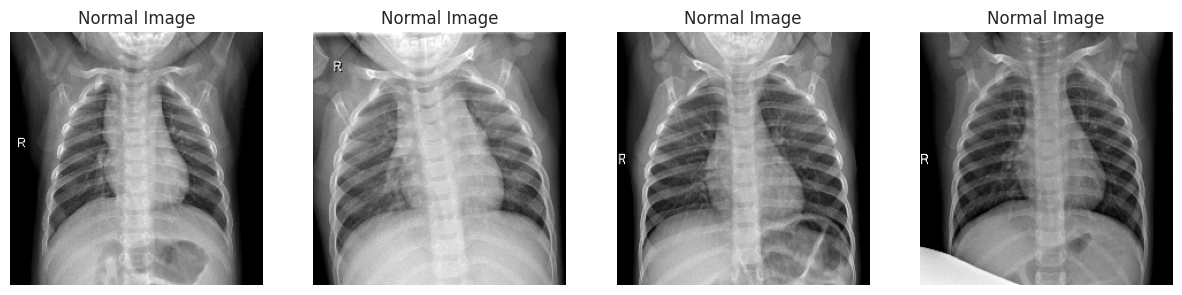

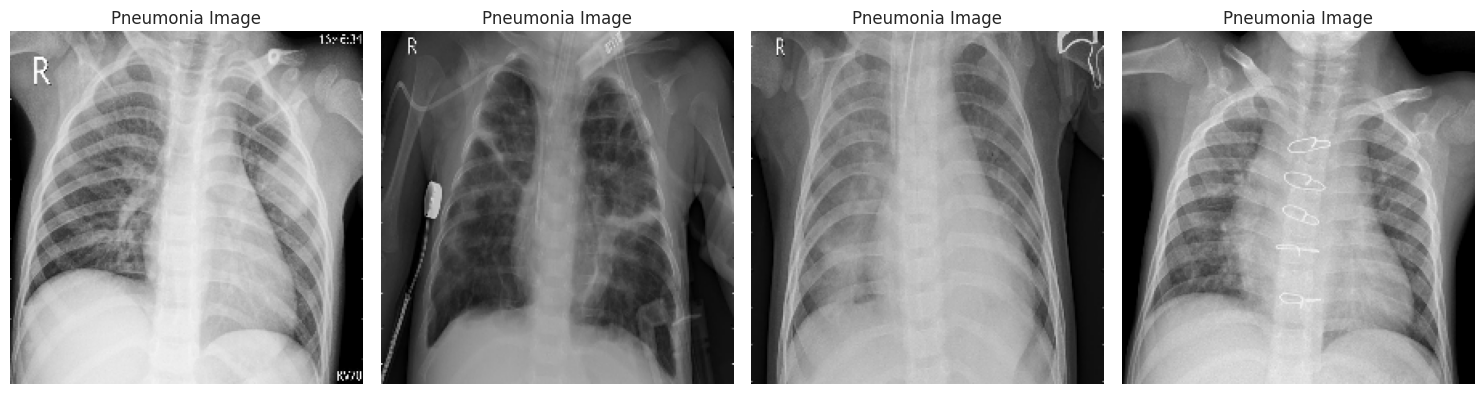

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Normal Image")


plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Pneumonia Image")
fig.tight_layout()
plt.show()

## Data Augmentation

In [ ]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train = train_val_generator.flow_from_directory(train_path,
                                               batch_size=128,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")



Found 5216 images belonging to 2 classes.


In [ ]:
val = train_val_generator.flow_from_directory(val_path,
                                               batch_size=4,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [ ]:
test = test_generator.flow_from_directory(test_path,
                                          batch_size=32,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 624 images belonging to 2 classes.


## Deep Residual Network (ResNet)

In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

In [ ]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False

model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))


## Compining the Model

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36410113 (138.89 MB)
Trainable params: 12845313 (49.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


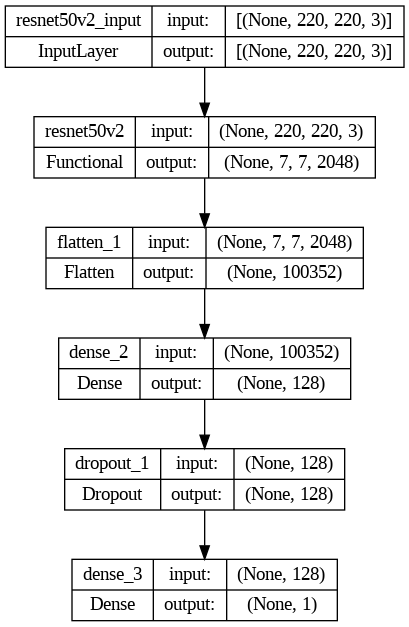

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_layer_names=True, show_shapes=True)



In [ ]:
hist = model.fit(train,validation_data=val,epochs=5)

## Evaluate the Model

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(hist.history['loss'], color='b', label="Training loss")
plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [ ]:
test_results = model.evaluate(test)

In [ ]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/Models/X-ray.h5')